## Loading the data

In [3]:
import os
import pandas as pd
import numpy as np

DBPEDIA_DIR = 'data/dbpedia_data'
DATA_DIR = 'data'

train_data_path = os.path.join(DBPEDIA_DIR, 'train.csv')
test_data_path = os.path.join(DBPEDIA_DIR, 'test.csv')

train_df = pd.read_csv(train_data_path, header=None, names=['class', 'title', 'text'])
display(train_df.head())
display(train_df.shape)
test_df = pd.read_csv(test_data_path, header=None, names=['class', 'title', 'text'])
display(test_df.head())
display(test_df.shape)

,class,title,text
0,1,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...
1,1,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...
2,1,Q-workshop,Q-workshop is a Polish company located in Poz...
3,1,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...
4,1,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...


(560000, 3)

,class,title,text
0,1,TY KU,TY KU /taɪkuː/ is an American alcoholic bever...
1,1,Odd Lot Entertainment,OddLot Entertainment founded in 2001 by longt...
2,1,Henkel,Henkel AG & Company KGaA operates worldwide w...
3,1,GOAT Store,The GOAT Store (Games Of All Type Store) LLC ...
4,1,RagWing Aircraft Designs,RagWing Aircraft Designs (also called the Rag...


(70000, 3)

## Preprocessing text

In [4]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saileshpatnala/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saileshpatnala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 

def preprocess_text(text):
    # removing numbers
    text = re.sub('[0-9]+', '', text)
    
    # removing urls
    text = re.sub(r'http\S+', '', text)
    
    # removing punctuation and special characters
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # convert to lowercase and lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # remove stop words
    keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
    
    # remove small words
    keywords = [word for word in keywords if len(word) > 2]
    
    return keywords

train_df['preprocess_text'] = train_df.text.apply(preprocess_text)
test_df['preprocess_text'] = test_df.text.apply(preprocess_text)
train_df.head()
test_df.head()

,class,title,text,preprocess_text
0,1,TY KU,TY KU /taɪkuː/ is an American alcoholic bever...,"[taɪkuː, american, alcoholic, beverage, compan..."
1,1,Odd Lot Entertainment,OddLot Entertainment founded in 2001 by longt...,"[oddlot, entertainment, found, longtime, produ..."
2,1,Henkel,Henkel AG & Company KGaA operates worldwide w...,"[henkel, company, kgaa, operate, worldwide, le..."
3,1,GOAT Store,The GOAT Store (Games Of All Type Store) LLC ...,"[goat, store, game, type, store, llc, one, lar..."
4,1,RagWing Aircraft Designs,RagWing Aircraft Designs (also called the Rag...,"[ragwing, aircraft, design, also, call, ragwin..."


Saving preprocessed data to pkl file

In [6]:
train_df.to_pickle(os.path.join(DATA_DIR, 'train_preprocessed.pkl'))
test_df.to_pickle(os.path.join(DATA_DIR, 'test_preprocessed.pkl'))

## Generating word embeddings
**NOTE:** This step can be skipped if you already have the model binaries (i.e. `dbpedia.wordembeddings` and `dbpedia.wordembeddings.npy`)

In [ ]:
from gensim.models import Word2Vec

all_text = pd.concat([train_df.preprocess_text, test_df.preprocess_text], axis=0)
w2v_model = Word2Vec(sentences=all_text, size=300, min_count=1, window=5, workers=4, sg=1)
w2v_model.wv.vectors.shape

(672056, 300)

Saving the word embeddings

In [ ]:
w2v_model.wv.save(os.path.join(DATA_DIR, 'dbpedia.wordembeddings'))

## Generating word vectors for text
Loading word embeddings

In [ ]:
import os
import pandas as pd
from gensim.models import KeyedVectors

word_vectors = KeyedVectors.load(os.path.join(DATA_DIR, 'dbpedia.wordembeddings'), mmap='r')

def vectorize_text(text, wv):
    """
    Function to vectorize text by averaging the word vectors 
    for each word in the text
    """
    vec = np.zeros((1, 300))
    for w in text:
        vec += wv.get_vector(w)

    return vec / len(text)

train_df = pd.read_pickle(os.path.join(DATA_DIR, 'train_preprocessed.pkl'))
test_df = pd.read_pickle(os.path.join(DATA_DIR, 'test_preprocessed.pkl'))
train_df['text_vec'] = train_df.preprocess_text.apply(vectorize_text, args=(word_vectors,))
test_df['text_vec'] = test_df.preprocess_text.apply(vectorize_text, args=(word_vectors,)) 

In [34]:
train_df.text_vec

0         [[0.13144679071212356, -0.087081287775866, -0....
1         [[0.10442016725428402, -0.003829245441011153, ...
2         [[0.16378618261175384, 0.15912020345179675, -0...
3         [[0.09676695337984711, 0.10167943956330419, -0...
4         [[0.09408356885736187, 0.1792608917846034, 0.0...
                                ...                        
559995    [[0.26903357211914325, -0.0898169663721799, 0....
559996    [[0.2265617781185678, 0.19878128323970096, -0....
559997    [[0.23648377436706247, -0.060604066259282476, ...
559998    [[0.3331511567812413, 0.23145836793507138, -0....
559999    [[0.26185702794993465, -0.024215461823835292, ...
Name: text_vec, Length: 560000, dtype: object

In [36]:
train_vec = pd.DataFrame(train_df.text_vec.explode().tolist())
test_vec = pd.DataFrame(test_df.text_vec.explode().tolist())

In [39]:
pd.concat([train_vec, train_df['class']], axis=1).to_pickle(os.path.join(DATA_DIR, 'dbpedia_train_wv.pkl'))
pd.DataFrame(train_vec).to_pickle(os.path.join(DATA_DIR, 'dbpedia_train_all_x.pkl'))
pd.DataFrame(train_df['class']).to_pickle(os.path.join(DATA_DIR, 'dbpedia_train_all_y.pkl'))
pd.concat([test_vec, test_df['class']]).to_pickle(os.path.join(DATA_DIR, 'dbpedia_test_wv.pkl'))

## Generating label splits
We're generating multiple datasets with different proportions of the training data that is labelled and unlabelled. We will be using these splits to benchmark the performance of our sem-supervised learning model:
* Label Split 1: 2000 data pts / class (5% of dataset)
* Label Split 2: 500 data pts / class (1.25% dataset)

In [44]:
# reading data from pkl binary files
import os
import pickle
import pandas as pd
import numpy as np

train_df = pd.read_pickle(os.path.join(DATA_DIR, 'dbpedia_train_wv.pkl'))
train_vec = pd.read_pickle(os.path.join(DATA_DIR, 'dbpedia_train_all_x.pkl'))

(array([40000., 40000., 40000., 40000., 40000., 40000., 40000., 40000.,
        40000., 40000., 40000., 40000., 80000.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <BarContainer object of 13 artists>)

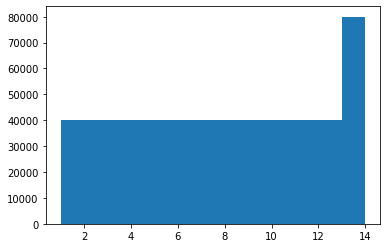

In [45]:
import matplotlib.pyplot as plt

classes = np.unique(train_df['class'])
plt.hist(train_df['class'], bins=classes)

In [46]:
num_per_class_label_split1 = 2000
num_per_class_label_split2 = 500

# final dataframes
x_split1_df, y_split1_df = pd.DataFrame(columns=['text_vec']), pd.DataFrame(columns=['class'])
x_split2_df, y_split2_df = pd.DataFrame(columns=['text_vec']), pd.DataFrame(columns=['class'])

classes = np.unique(train_df['class'])
for c in classes:
    c_idx = np.where(train_df['class'] == c)[0]
    # generating split 1
    split1_idx = random.sample(c_idx.tolist(), num_per_class_label_split1)
    x_split1_df = x_split1_df.append(pd.DataFrame(train_vec.iloc[split1_idx]))
    y_split1_df = y_split1_df.append(pd.DataFrame(train_df['class'].iloc[split1_idx]))
    # generating split 2
    split2_idx = random.sample(c_idx.tolist(), num_per_class_label_split2)
    x_split2_df = x_split2_df.append(pd.DataFrame(train_vec.iloc[split2_idx]))
    y_split2_df = y_split2_df.append(pd.DataFrame(train_df['class'].iloc[split2_idx]))

x_split1_df

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,text_vec
3615,0.098823,0.123259,-0.124229,-0.201926,-0.053362,-0.352179,0.132459,0.056637,-0.038723,0.276486,...,0.069113,-0.303163,0.059698,0.093906,0.190502,-0.145364,-0.124307,-0.365310,0.199004,NaN
20876,-0.028990,-0.009980,-0.159153,-0.185463,-0.056336,-0.361043,0.160740,0.064434,-0.059939,0.204590,...,0.215283,-0.234558,0.174565,0.155218,0.201988,-0.230418,-0.215207,-0.202544,0.123528,NaN
1408,0.241497,0.174082,-0.051192,-0.252088,-0.215398,-0.393107,0.353254,0.264694,-0.105870,0.137138,...,0.041419,-0.215415,0.071415,0.087759,0.232199,-0.126035,-0.176790,-0.267857,0.138401,NaN
6516,0.231510,0.202784,-0.003460,-0.145731,-0.147072,-0.136671,0.165152,0.180928,-0.011031,0.236621,...,0.071131,-0.276998,0.056529,0.062647,0.318937,-0.186477,-0.243302,-0.208458,0.167562,NaN
4632,0.146614,0.218499,-0.121149,-0.064579,-0.094156,-0.420317,0.310276,0.133986,0.023828,0.185953,...,0.036964,-0.094330,-0.009066,0.183578,0.043248,-0.220455,-0.148722,-0.324121,0.174671,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541041,0.295498,0.050380,-0.019490,-0.322956,-0.199220,-0.081211,0.238051,0.191839,0.072735,0.273592,...,0.057061,-0.206660,0.064773,0.007946,0.314043,-0.105267,-0.361848,-0.196275,0.206427,NaN
555702,0.199347,-0.082539,0.007432,-0.379936,-0.141194,-0.132088,0.267515,0.309471,0.008967,0.154896,...,0.098342,-0.161676,0.125211,0.029346,0.281684,-0.151593,-0.228862,-0.119803,0.188390,NaN
527785,0.165815,0.105254,-0.026658,-0.192110,-0.152640,-0.081904,0.095401,0.143545,-0.002483,0.185291,...,0.081052,-0.043643,0.078491,0.100219,0.127774,-0.068161,-0.089514,-0.171730,0.093184,NaN
533193,0.259417,0.144218,-0.001619,-0.383171,-0.422604,0.077478,0.359156,0.357677,0.072535,0.315306,...,0.199681,-0.089557,0.076634,0.058800,0.369157,-0.096915,-0.296347,-0.270312,0.276559,NaN


In [50]:
import random

def generate_label_splits(train_df, train_vec):
    """
    Function to generate the label splits
    """
    num_per_class_label_split1 = 2000
    num_per_class_label_split2 = 500

    # final dataframes
    x_split1_df, y_split1_df = pd.DataFrame(), pd.DataFrame()
    x_split2_df, y_split2_df = pd.DataFrame(), pd.DataFrame()

    classes = np.unique(train_df['class'])
    for c in classes:
        c_idx = np.where(train_df['class'] == c)[0]
        # generating split 1
        split1_idx = random.sample(c_idx.tolist(), num_per_class_label_split1)
        x_split1_df = x_split1_df.append(pd.DataFrame(train_vec.iloc[split1_idx]))
        y_split1_df = y_split1_df.append(pd.DataFrame(train_df['class'].iloc[split1_idx]))
        # generating split 2
        split2_idx = random.sample(c_idx.tolist(), num_per_class_label_split2)
        x_split2_df = x_split2_df.append(pd.DataFrame(train_vec.iloc[split2_idx]))
        y_split2_df = y_split2_df.append(pd.DataFrame(train_df['class'].iloc[split2_idx]))

    x_split1_df.to_pickle(os.path.join(DATA_DIR, 'dbpedia_train_x_split1.pkl'))
    y_split1_df.to_pickle(os.path.join(DATA_DIR, 'dbpedia_train_y_split1.pkl'))
    x_split2_df.to_pickle(os.path.join(DATA_DIR, 'dbpedia_train_x_split2.pkl'))
    y_split2_df.to_pickle(os.path.join(DATA_DIR, 'dbpedia_train_y_split2.pkl'))

generate_label_splits(train_df, train_vec)